In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# try:
#   from rclp import rclp.LinearPool
# except:
#   !pip install git+https://github.com/reichlab/qenspy@params
#   from qenspy import qens

from rclp.rclp import LinearPool, BetaMixtureRCLP

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from numpy.random import default_rng
from scipy.stats import norm

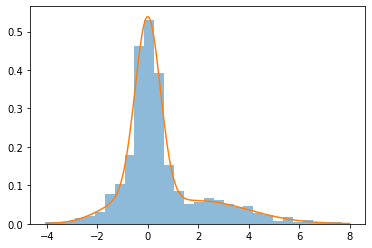

In [2]:
# simulate data from a mixture of normal distributions
# mixture parameters
w = [0.1, 0.6, 0.3]
mu = np.array([-1.0, 0.0, 2.0])
sigma = np.array([1.0, 0.5, 2.0])

# sample size
n = 1000

# init rng
rng = default_rng(42)

# mixture component indicator; there is probably a better way?
z = np.argmax(rng.multinomial(n=1, pvals=w, size=n), axis=1)

# sampled values of outcome variable
y = rng.standard_normal(n) * sigma[z] + mu[z]

# make a plot with histogram of sampled values and exact density of the mixture
y_grid = np.linspace(start=-4.0, stop=8.0, num=201)
f = w[0] * norm.pdf(y_grid, loc=mu[0], scale=sigma[0]) + \
    w[1] * norm.pdf(y_grid, loc=mu[1], scale=sigma[1]) + \
    w[2] * norm.pdf(y_grid, loc=mu[2], scale=sigma[2])
plt.hist(y, bins=30, density=True, histtype='stepfilled', alpha=0.5)
plt.plot(y_grid, f)
plt.show()

In [3]:
# fit a weighted linear pool to attempt to recover the mixture weights,
# assuming the component distributions are known

# first, calculate the log pdf and cdf values of each y from the component distributions
# arranged in arrays of shape (1000, 3)
component_log_prob = np.stack(
    [norm.logpdf(y, loc=mu[i], scale=sigma[i]) for i in range(3)],
    axis=1)
component_log_cdf = np.stack(
    [norm.logcdf(y, loc=mu[i], scale=sigma[i]) for i in range(3)],
    axis=1)

# define a linear pool object for 3 component models and fit it
lp = LinearPool(M=3)
lp.fit(component_log_prob=component_log_prob, component_log_cdf=component_log_cdf,
       optim_method="adam", num_iter=100, learning_rate=0.1)

# look at the fitted parameter values -- compare to the true values of [0.1, 0.6, 0.3]
lp.parameters

2022-09-22 22:45:14.930646: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


{'lp_w': <TransformedVariable: name=lp_w, dtype=float32, shape=[3], fn="softmax_centered", numpy=array([0.10811801, 0.5888711 , 0.30301082], dtype=float32)>}

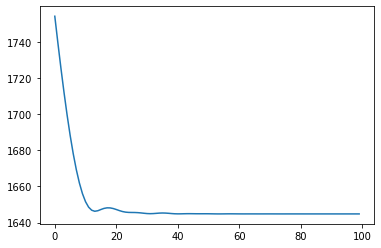

In [4]:
# plot loss trace
# if optimization was successful, this should have stabilized around a low value
plt.plot(lp.loss_trace)

# Example where component forecasters are misspecified

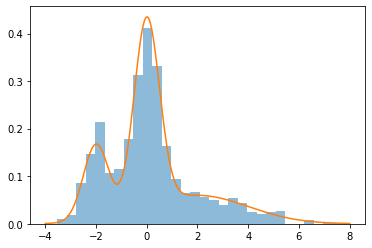

In [5]:
# simulate data from a mixture of normal distributions
# mixture parameters
w = [0.2, 0.5, 0.3]
mu = np.array([-2.0, 0.0, 2.0])
sigma = np.array([0.5, 0.5, 2.0])

# sample size
n = 1000

# init rng
rng = default_rng(42)

# mixture component indicator; there is probably a better way?
z = np.argmax(rng.multinomial(n=1, pvals=w, size=n), axis=1)

# sampled values of outcome variable
y = rng.standard_normal(n) * sigma[z] + mu[z]

# make a plot with histogram of sampled values and exact density of the mixture
y_grid = np.linspace(start=-4.0, stop=8.0, num=201)
f = w[0] * norm.pdf(y_grid, loc=mu[0], scale=sigma[0]) + \
    w[1] * norm.pdf(y_grid, loc=mu[1], scale=sigma[1]) + \
    w[2] * norm.pdf(y_grid, loc=mu[2], scale=sigma[2])
F = w[0] * norm.cdf(y_grid, loc=mu[0], scale=sigma[0]) + \
    w[1] * norm.cdf(y_grid, loc=mu[1], scale=sigma[1]) + \
    w[2] * norm.cdf(y_grid, loc=mu[2], scale=sigma[2])
plt.hist(y, bins=30, density=True, histtype='stepfilled', alpha=0.5)
plt.plot(y_grid, f)
plt.show()

In [6]:
# fit a weighted linear pool,
# assuming the component distributions are known but misspecified

# component parameters
component_mu = np.array([-1.0, 1.0])
component_sigma = np.array([1.0, 1.0])

# calculate the log pdf and cdf values of each y from the component distributions
# arranged in arrays of shape (1000, 2)
component_log_prob = np.stack(
    [norm.logpdf(y, loc=component_mu[i], scale=component_sigma[i]) for i in range(2)],
    axis=1)
component_log_cdf = np.stack(
    [norm.logcdf(y, loc=component_mu[i], scale=component_sigma[i]) for i in range(2)],
    axis=1)

# define a linear pool object for 2 component models and fit it
lp = LinearPool(M=2)
lp.fit(component_log_prob=component_log_prob, component_log_cdf=component_log_cdf,
       optim_method="adam", num_iter=100, learning_rate=0.1)

# estimated ensemble parameters
lp.parameters

{'lp_w': <TransformedVariable: name=lp_w, dtype=float32, shape=[2], fn="softmax_centered", numpy=array([0.5274734 , 0.47252658], dtype=float32)>}

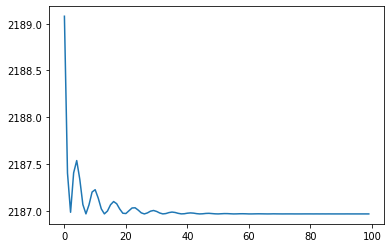

In [7]:
# plot loss trace
plt.plot(lp.loss_trace)

In [8]:
# fit a beta mixture recalibrated linear pool with K=1 mixture component
beta_mixt_rclp_K1 = BetaMixtureRCLP(M=2, K=1)
beta_mixt_rclp_K1.fit(component_log_prob=component_log_prob, component_log_cdf=component_log_cdf,
              optim_method="adam", num_iter=100, learning_rate=0.1)

# estimated ensemble parameters
beta_mixt_rclp_K1.parameters

{'rc_pi': <TransformedVariable: name=rc_pi, dtype=float32, shape=[1], fn="softmax_centered", numpy=array([1.], dtype=float32)>,
 'rc_alpha': <TransformedVariable: name=rc_alpha, dtype=float32, shape=[1], fn="softplus", numpy=array([0.8727781], dtype=float32)>,
 'rc_beta': <TransformedVariable: name=rc_beta, dtype=float32, shape=[1], fn="softplus", numpy=array([0.4027635], dtype=float32)>,
 'lp_w': <TransformedVariable: name=lp_w, dtype=float32, shape=[2], fn="softmax_centered", numpy=array([0.9442742 , 0.05572576], dtype=float32)>}

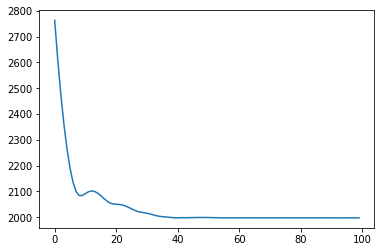

In [9]:
# plot loss trace
plt.plot(beta_mixt_rclp_K1.loss_trace)

In [10]:
# fit a beta mixture recalibrated linear pool with K=10 mixture components
beta_mixt_rclp_K10 = BetaMixtureRCLP(M=2, K=10)
beta_mixt_rclp_K10.fit(component_log_prob=component_log_prob, component_log_cdf=component_log_cdf,
              optim_method="adam", num_iter=1000, learning_rate=0.1)

# estimated ensemble parameters
beta_mixt_rclp_K10.parameters

{'rc_pi': <TransformedVariable: name=rc_pi, dtype=float32, shape=[10], fn="softmax_centered", numpy=
 array([1.24392875e-01, 1.79817507e-04, 8.04147276e-04, 3.07718059e-04,
        2.33961880e-01, 7.63042346e-02, 4.41582538e-02, 7.99900759e-03,
        3.83907650e-03, 5.08053064e-01], dtype=float32)>,
 'rc_alpha': <TransformedVariable: name=rc_alpha, dtype=float32, shape=[10], fn="softplus", numpy=
 array([10.919974 ,  1.5368645,  2.035804 ,  1.5708389,  1.8808633,
         4.3335514,  3.634417 ,  1.5345129,  1.9597634,  5.5101213],
       dtype=float32)>,
 'rc_beta': <TransformedVariable: name=rc_beta, dtype=float32, shape=[10], fn="softplus", numpy=
 array([ 0.29629642,  4.5222774 ,  4.0640755 ,  3.3515034 , 30.39037   ,
         1.957043  ,  2.087684  ,  0.29731306,  0.29708847, 10.302954  ],
       dtype=float32)>,
 'lp_w': <TransformedVariable: name=lp_w, dtype=float32, shape=[2], fn="softmax_centered", numpy=array([0.28236505, 0.717635  ], dtype=float32)>}

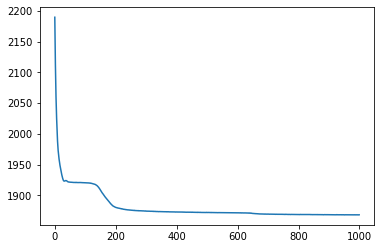

In [11]:
# plot loss trace
plt.plot(beta_mixt_rclp_K10.loss_trace)

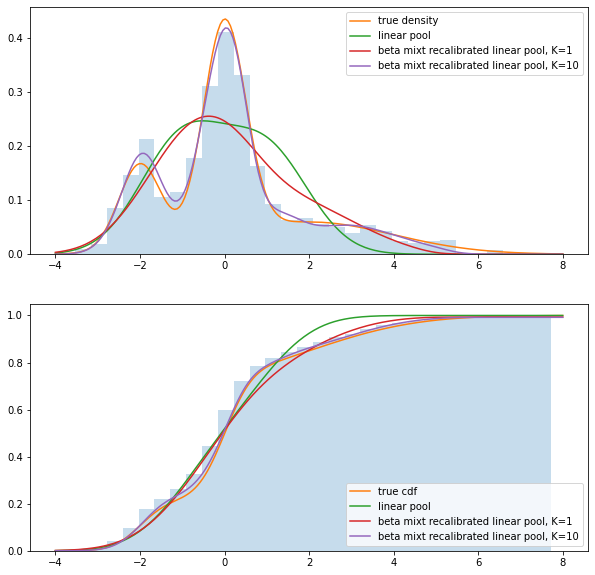

In [12]:
# calculate and plot densities from the linear pool
# and the beta recalibrated linear pool
y_grid_log_f = np.stack([norm.logpdf(y_grid, loc=component_mu[i], scale=component_sigma[i]) for i in range(2)], axis=1)
y_grid_log_F = np.stack([norm.logcdf(y_grid, loc=component_mu[i], scale=component_sigma[i]) for i in range(2)], axis=1)

lp_prob = lp.prob(y_grid_log_f, y_grid_log_F)
beta_mixt_rclp_K1_prob = beta_mixt_rclp_K1.prob(y_grid_log_f, y_grid_log_F)
beta_mixt_rclp_K10_prob = beta_mixt_rclp_K10.prob(y_grid_log_f, y_grid_log_F)

lp_cdf = lp.cdf(y_grid_log_F)
beta_mixt_rclp_K1_cdf = beta_mixt_rclp_K1.cdf(y_grid_log_F)
beta_mixt_rclp_K10_cdf = beta_mixt_rclp_K10.cdf(y_grid_log_F)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].hist(y, bins=30, density=True, histtype='stepfilled', alpha=0.25)
ax[0].plot(y_grid, f, label='true density')
ax[0].plot(y_grid, lp_prob, label='linear pool')
ax[0].plot(y_grid, beta_mixt_rclp_K1_prob, label='beta mixt recalibrated linear pool, K=1')
ax[0].plot(y_grid, beta_mixt_rclp_K10_prob, label='beta mixt recalibrated linear pool, K=10')
ax[0].legend()

ax[1].hist(y, bins=30, density=True, cumulative=True, histtype='stepfilled', alpha=0.25)
ax[1].plot(y_grid, F, label='true cdf')
ax[1].plot(y_grid, lp_cdf, label='linear pool')
ax[1].plot(y_grid, beta_mixt_rclp_K1_cdf, label='beta mixt recalibrated linear pool, K=1')
ax[1].plot(y_grid, beta_mixt_rclp_K10_cdf, label='beta mixt recalibrated linear pool, K=10')
ax[1].legend()

plt.show()